In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
key = random.PRNGKey(0)
import pandas as pd

from utils import uniaxial_relax, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_gov_vmap, dPhi_vmap, plot45
from utils import uniaxial_monotone

In [2]:
# Functions for training
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 


# Define loss functions
def uniaxial_relax_loss(params, norm, useNODE, inp, out):
    sigma_pr,_,_,_,_,_,_ = uniaxial_relax(params, norm, useNODE, inp[0], inp[1])
    loss = np.mean((sigma_pr[:,0,0]-out)**2)# + (sigma_pr[:,1,1]-out[1])**2)
    return loss
uniaxial_relax_loss_vmap = vmap(uniaxial_relax_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
uniaxial_relax_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(uniaxial_relax_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.average((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

# 1. Train Govindjee's model
Set dt0=0.1 or 0.5 for this module

In [3]:
with open('training_data/Rubber/HDR/singlestep.npy','rb') as f:
    time, lm, sgm_x = np.load(f)
time = np.expand_dims(time,0)
time = np.abs(time)
lmb_x = np.expand_dims(lm,0)
sgm_x = np.expand_dims(sgm_x,0)

inp = np.array([time, lmb_x]).transpose([1,0,2])
out = sgm_x

In [4]:
# Initial guesses for material parameters
mu = 77.77*0.1
K = 1.0
gov_Psi_eq_params = [K, mu]
gov_Psi_neq_params = [K, mu]

eta_D = 1360.0
eta_V = 175000.0
gov_Phi_params = [np.log(eta_D*0.1), np.log(eta_V*0.1)]

gov_params = [gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params]
gov_norm = (1.0, 1.0, 1.0)

with open('saved/brain_CR_gov_params.npy', 'rb') as f: #initial guess
    gov_params = pickle.load(f)

In [ ]:
lr = 1.0e-3
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(gov_params)

gov_params, train_loss, val_loss = train(inp, out, gov_norm, False, opt_state, key, uniaxial_relax_batch_loss, nIter = 120000, batch_size=1, print_freq=10000)
    
with open('saved/NR1_gov_params.npy', 'wb') as f:
    pickle.dump(gov_params, f)

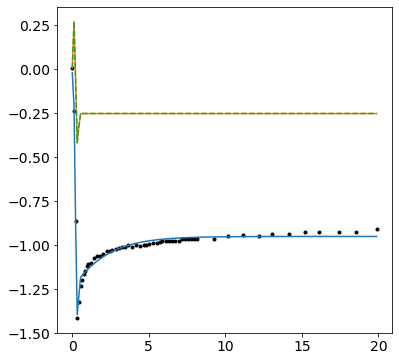

In [6]:
fig, ax = plt.subplots(figsize=[6,6])
sigm_pr, lm1, lm2, lm3, lm1e, lm2e, lm3e = uniaxial_relax(gov_params, gov_norm, False, time[0], lmb_x[0])
 
ax.plot(time[0],sgm_x[0],'k.')
ax.plot(time[0],sigm_pr[:,0,0])
ax.plot(time[0],sigm_pr[:,1,1])
ax.plot(time[0],sigm_pr[:,2,2], '--')

# 2. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [7]:
with open('saved/NR1_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params

In [8]:
# Generate training data
# Inputs
lm = np.linspace(0.7,1.4,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_eq_params)

## 2.1 $\Psi_{EQ}$

In [9]:
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 50000, batch_size=10, print_freq=10000)
    
with open('saved/NR1_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 1.304530e+05
it 10000, train loss = 1.302196e+05
it 20000, train loss = 1.302196e+05
it 30000, train loss = 1.302196e+05
it 40000, train loss = 1.302196e+05
it 50000, train loss = 1.302196e+05


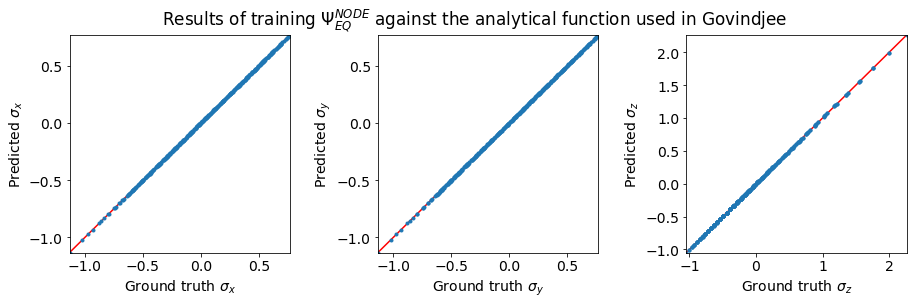

In [10]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 2.2 $\Psi_{NEQ}$

In [11]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 50000, batch_size=10, print_freq=10000)

with open('saved/NR1_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 1.314822e+05
it 10000, train loss = 1.312401e+05
it 20000, train loss = 1.312401e+05
it 30000, train loss = 1.312401e+05
it 40000, train loss = 1.312401e+05
it 50000, train loss = 1.312401e+05


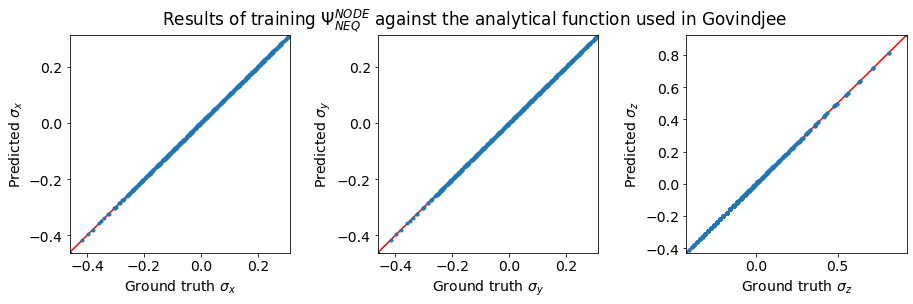

In [12]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 3. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [13]:
with open('saved/NR1_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params
eta_D, eta_V = gov_Phi_params

In [14]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-200:200:10j, -200:200:10j, -200:200:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

# inp_std1 = onp.std(tau1)
# inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

# out_std1 = 1.0
# out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [15]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 100000, batch_size=100, print_freq=10000)

with open('saved/NR1_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/NR1_Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 6.701935e+04
it 10000, train loss = 6.660766e+04
it 20000, train loss = 6.598848e+04
it 30000, train loss = 6.457911e+04
it 40000, train loss = 6.083975e+04
it 50000, train loss = 5.072900e+04
it 60000, train loss = 2.690645e+04
it 70000, train loss = 4.416162e+02
it 80000, train loss = 1.722794e-02
it 90000, train loss = 1.736693e-02
it 100000, train loss = 1.796647e-02


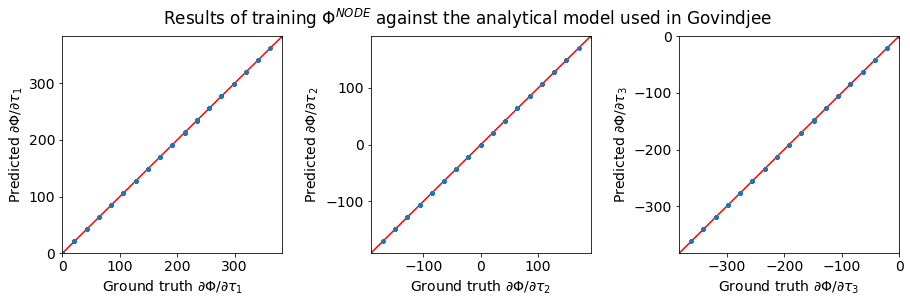

In [16]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Test
Set dt0=0.01 for this module

In [3]:
#Load the pre-trained parameters
with open('saved/NR1_Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/NR1_Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/NR1_Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/NR1_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('training_data/Rubber/NR1/singlestep.npy','rb') as f:
    time, lm, sgm_x = np.load(f)
time = np.expand_dims(time,0)
time = np.abs(time)
lmb_x = np.expand_dims(lm,0)
sgm_x = np.expand_dims(sgm_x,0)


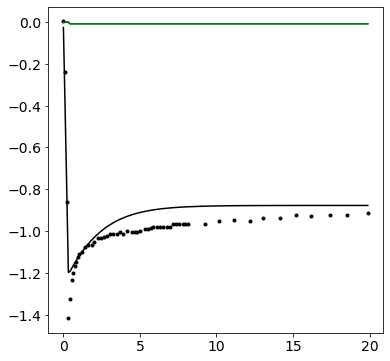

In [4]:
fig, ax = plt.subplots(figsize=(6,6))

t = time[0]
sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(params, norm, True, t, lmb_x[0])

ax.plot(t, sgm_x[0], 'k.')
ax.plot(t,sig_NN[:,0,0],'k-')
ax.plot(t,sig_NN[:,1,1],'b-')
ax.plot(t,sig_NN[:,2,2],'g-')

# 5. Retrain
Set dt0=0.01 for this module

2022-12-10 23:35:50.878360: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_step.46
********************************


it 0, train loss = 5.529353e-03
it 100, train loss = 2.062965e-03
it 200, train loss = 1.554672e-03
it 300, train loss = 1.370430e-03
it 400, train loss = 1.233879e-03
it 500, train loss = 1.116496e-03
it 600, train loss = 9.934228e-04
it 700, train loss = 8.780578e-04
it 800, train loss = 8.039178e-04
it 900, train loss = 7.584372e-04
it 1000, train loss = 7.257508e-04
it 1100, train loss = 7.068662e-04
it 1200, train loss = 6.884044e-04
it 1300, train loss = 6.780847e-04
it 1400, train loss = 6.642245e-04
it 1500, train loss = 6.546523e-04
it 1600, train loss = 6.458489e-04
it 1700, train loss = 6.380774e-04
it 1800, train loss = 6.311326e-04
it 1900, train loss = 6.251833e-04
it 2000, train loss = 6.190914e-04


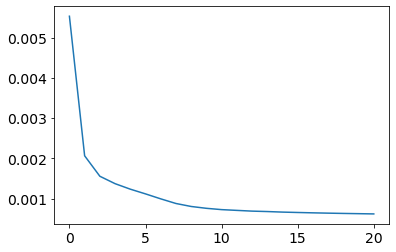

In [5]:
opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(params)

inp = np.array([time, lmb_x]).transpose([1,0,2])
out = sgm_x

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, uniaxial_relax_batch_loss, nIter = 2000, batch_size=1, print_freq=100)

with open('saved/NR1_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

plt.plot(train_loss)

# 6. Final test

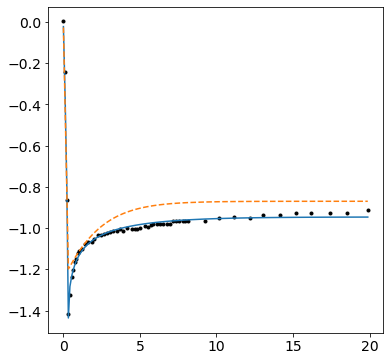

In [24]:
with open('saved/NR1_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
with open('training_data/Rubber/NR1/singlestep.npy','rb') as f:
    time, lm, sgm_x = np.load(f)
time = np.expand_dims(time,0)
time = np.abs(time)
lmb_x = np.expand_dims(lm,0)
sgm_x = np.expand_dims(sgm_x,0)
with open('saved/NR1_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)

with open('saved/NR1_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
norm = (None, None, Phi_norm)


fig, ax = plt.subplots(figsize=(6,6))

t = time[0]
sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(params, norm, True, t, lmb_x[0])
sig_RG, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax(gov_params, norm, False, t, lmb_x[0])

ax.plot(t, sgm_x.flatten(), 'k.')
ax.plot(t, sig_NN[:,0,0])
ax.plot(t, sig_RG[:,0,0], '--')

data = np.array([t, sgm_x.flatten(), sig_NN[:,0,0], sig_RG[:,0,0]])
columns = ['x', 'y_gt', 'y_nn', 'y_rg']
df = pd.DataFrame(data.T, columns=columns)
df.to_csv('tikz_data/fig_rubber/fig_rubber_a.csv', index=False, sep=' ')

Test with monotone compression data

In [25]:
with open('saved/NR1_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
with open('training_data/Rubber/NR1/singlestep.npy','rb') as f:
    time, lm, sgm_x = np.load(f)
with open('saved/NR1_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
time = np.expand_dims(time,0)
time = np.abs(time)
lmb_x = np.expand_dims(lm,0)
sgm_x = np.expand_dims(sgm_x,0)
with open('saved/NR1_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
norm = (None, None, Phi_norm)

[(-3.7, 0.2)]

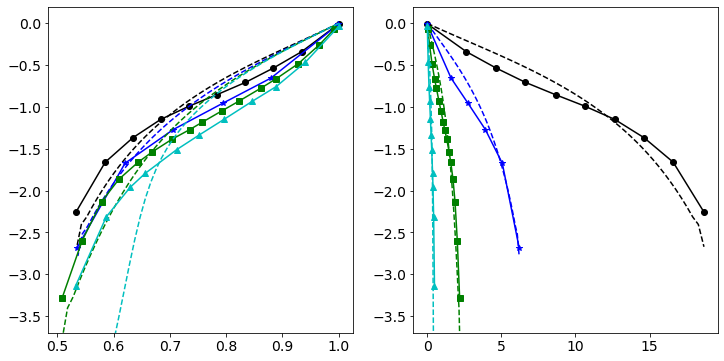

In [37]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
loading_rates = [0.025, 0.075, 0.225,  0.96]
gt_markers    = ['ko-', 'b*-', 'gs-', 'c^-']
pr_markers    = ['k--', 'b--', 'g--', 'c--']
tikz_gt = []
tikz_nn = []
for lr, gt_marker, pr_marker in zip(loading_rates, gt_markers, pr_markers):
    data = onp.genfromtxt('training_data/Rubber/NR1/monotonic_comp/'+str(lr) + '.csv', delimiter=',')
    data = np.flip(data,axis=0)
    lmb_x = data[:,0]
    sgm_x = data[:,1]
    len_data = sgm_x.shape[0]

    time = onp.zeros(len_data)
    for i in range(len_data):
        t = (1.0-lmb_x[i])/lr
        time[i] = t
    t_peak = time[-1]
    dt0 = t_peak/40.0
    time2 = np.linspace(time[0],time[-1],50)
    
    sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN = uniaxial_monotone(params, norm, True, time2, -lr, t_peak, dt0)
    sig_RG, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN = uniaxial_monotone(gov_params, norm, False, time2, -lr, t_peak, dt0)
    

    data = np.flip(data,axis=0)
    ax[0].plot(data[:,0], data[:,1], gt_marker)
    ax[0].plot(lm1_NN, sig_NN[:,0,0], pr_marker)
    ax[1].plot(time, sgm_x, gt_marker)
    ax[1].plot(time2, sig_NN[:,0,0], pr_marker)

    tikz_gt.append(np.array([time, sgm_x]))
    tikz_nn.append(np.array([time2, sig_NN[:,0,0], sig_RG[:,0,0]]))
ax[0].set(ylim = [-3.7,0.2])
ax[1].set(ylim = [-3.7,0.2])

In [39]:
panels = ['b1','b2','b3','b4']
for panel, gt_data, pr_data in zip(panels, tikz_gt, tikz_nn):
    columns = ['x', 'y_gt']
    df = pd.DataFrame(gt_data.T, columns=columns)
    df.to_csv('tikz_data/fig_rubber/fig_rubber_' + panel + '_gt.csv', index=False, sep=' ')

    columns = ['x', 'y_nn', 'y_rg']
    df = pd.DataFrame(pr_data.T, columns=columns)
    df.to_csv('tikz_data/fig_rubber/fig_rubber_' + panel + '_pr.csv', index=False, sep=' ')

In [9]:
panels = ['b1','b2','b3','b4']
loading_rates = [0.025, 0.075, 0.225,  0.96]
nn = []
rg = []
for panel, rate in zip(panels, loading_rates):
    data = pd.read_csv('tikz_data/fig_rubber/fig_rubber_' + panel + '_gt.csv', sep = ' ')
    pred = pd.read_csv('tikz_data/fig_rubber/fig_rubber_' + panel + '_pr.csv', sep = ' ')

    pr_nn = onp.interp(data.x, pred.x, pred.y_nn)
    pr_rg = onp.interp(data.x, pred.x, pred.y_rg)

    mae_nn = onp.mean(onp.abs(data.y_gt-pr_nn))
    mae_rg = onp.mean(onp.abs(data.y_gt-pr_rg))
    
    print('Strain rate = ', rate)
    print('NODE MAE = ', mae_nn)
    print('RG MAE = ', mae_rg)
    print('--------')
    
    nn.append(mae_nn)
    rg.append(mae_rg)
nn = onp.array(nn)
rg = onp.array(rg)
print('Averages: ', onp.mean(nn), onp.mean(rg))

Strain rate =  0.025
NODE MAE =  0.15781844881077262
RG MAE =  0.21808199195174033
--------
Strain rate =  0.075
NODE MAE =  0.13129876824769318
RG MAE =  0.34378565536337113
--------
Strain rate =  0.225
NODE MAE =  0.23106533935373838
RG MAE =  0.35146675255552895
--------
Strain rate =  0.96
NODE MAE =  0.6722005219192695
RG MAE =  0.41316511451001503
--------
Averages:  0.29809576958286843 0.3316248785951639
